# 240923.ver


In [2]:
from konlpy.tag import Okt
import re
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from itertools import zip_longest
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from tqdm import tqdm
import pickle
import glob
from datetime import datetime, timedelta


In [22]:
def load_stopwords(file_path):
    """
    file_path 경로에서 불용어를 불러오는 함수
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines()
    return stopwords


# def preprocess_text_with_ngrams(text, stopwords=None, n=2):
#     """
#     Okt를 사용한 텍스트 전처리 함수 (n-gram 포함)
#     - 불용어 제거
#     - 명사 추출 및 n-gram 생성
#     """
#     okt = Okt()
#     text = re.sub(r'\d+', '', text)  # 숫자 제거
#     text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    
#     nouns = okt.nouns(text)
    
#     if stopwords:
#         nouns = [word for word in nouns if word not in stopwords]
    
#     # n-gram 생성
#     ngrams = zip_longest(*[nouns[i:] for i in range(n)])
#     ngram_list = [' '.join(filter(None, ngram)) for ngram in ngrams]
    
#     return ngram_list


def preprocess_text(text, stopwords=None):
    """
    Okt를 사용한 텍스트 전처리 함수
    - 불용어 제거
    - 명사 추출
    """
    okt = Okt()
    # 정규 표현식을 사용한 숫자/특수문자 제거
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    nouns = okt.nouns(text)

    if stopwords:
        nouns = [word for word in nouns if word not in stopwords]
    
    # 길이가 1인 단어들 제거
    nouns = [word for word in nouns if len(word) > 1]

    processed_text = ' '.join(nouns)

    return processed_text


def load_and_merge_section_data(section_number, hours_back=9):
    """
    섹션 번호에 해당하는 모든 pkl 파일을 불러와서 기사 본문을 하나의 변수로 병합하는 함수
    현재 시간에서 -hours_back 시간 전까지의 파일만 병합
    """
    current_time = datetime.now()
    start_time = current_time - timedelta(hours=hours_back)

    valid_hours = []
    for hour in range(hours_back + 1): # 0부터 hours_back까지의 시간을 계산
        valid_hour = (start_time + timedelta(hours=hour)).strftime('%H')
        valid_hours.append(valid_hour)

    file_patterns = [f"./data/{section_number}/*_{hour}.pkl" for hour in valid_hours]

    merged_content = []
    for file_pattern in tqdm(file_patterns, desc=f"섹션 번호: {section_number} 파일"):
        file_list = glob.glob(file_pattern)

        for file_path in file_list:
            with open(file_path, 'rb') as file:
                print(file_path)
                data = pickle.load(file)
                for article in data:
                    merged_content.append(article['content'])

    merged_document = ' '.join(merged_content)

    return merged_document


def process_sections(section_numbers, stopwords_file_path, hours_back=9):
    """
    주어진 섹션 번호 리스트에 대해 각 섹션별로 데이터를 병합하고 전처리하는 함수
    """
    # 불용어 로드
    print("불용어를 불러오는 중입니다...")
    stopwords = load_stopwords(stopwords_file_path)

    processed_documents = {}

    for section_number in tqdm(section_numbers, desc="섹션 처리중"):
        # 데이터 병합
        merged_content = load_and_merge_section_data(section_number, hours_back)

        # 텍스트 전처리
        print(f"{section_number}번 텍스트 전처리 중...")
        processed_text = preprocess_text(merged_content, stopwords)

        # 섹션 번호를 키로 하여 전처리된 문서를 저장
        processed_documents[section_number] = processed_text

    return processed_documents

# def process_sections_with_ngrams(section_numbers, stopwords_file_path, hours_back=9, n=2):
#     """
#     주어진 섹션 번호 리스트에 대해 각 섹션별로 데이터를 병합하고 전처리하는 함수
#     - n: n-gram 크기, 기본값은 2
#     """
#     stopwords = load_stopwords(stopwords_file_path)
#     processed_documents = {}

#     for section_number in tqdm(section_numbers, desc="섹션 처리중"):
#         merged_content = load_and_merge_section_data(section_number, hours_back)
#         processed_text = preprocess_text_with_ngrams(merged_content, stopwords, n)
#         processed_documents[section_number] = processed_text

#     return processed_documents



def prepare_data_for_lda(doc):
    """
    LDA를 위한 데이터를 준비하는 함수
    - doc: 전처리된 텍스트 데이터 (단일 섹션의 텍스트)
    """
    # 전처리된 문서를 리스트로 변환
    text = doc.split()

    # 딕셔너리 생성
    dictionary = corpora.Dictionary([text])

    # 코퍼스 생성(단어의 빈도수로 변환된 텍스트 데이터)
    corpus = [dictionary.doc2bow(text)]

    return dictionary, corpus


# def prepare_data_for_lda(doc):
#     """
#     LDA를 위한 데이터를 준비하는 함수
#     - doc: 전처리된 텍스트 데이터 (단일 섹션의 텍스트)
#     """
#     dictionary = corpora.Dictionary([doc])
#     corpus = [dictionary.doc2bow(doc)]
#     return dictionary, corpus

def train_lda_model(dictionary, corpus, num_topics=5, passes=15):
    """
    LDA 모델을 학습하는 함수
    - dictionary: Gensim의 Dictionary 객체
    - corpus: Gensim의 코퍼스 객체
    - num_topics: 생성할 토픽의 수
    - passes: 학습 반복 횟수
    """
    
    # LDA 모델 학습
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         update_every=1,
                         passes=passes,
                         alpha='auto',
                         per_word_topics=True)
    
    return lda_model


def extract_topics_for_section(processed_docs, num_topics=1, num_words=10, passes=15):
    """
    각 섹션별로 토픽을 추출하는 함수
    - processed_docs: 전처리된 텍스트 데이터 (딕셔너리 형태, 섹션별로 저장됨)
    - num_topics: 생성할 토픽의 수
    - num_words: 각 토픽에 대해 출력할 단어 수
    - passes: 학습 반복 횟수
    """
    section_topics = {}

    for section, doc in tqdm(processed_docs.items(), desc="각 섹션별로 토픽을 추출합니다."):
        # 데이터 준비
        dictionary, corpus = prepare_data_for_lda(doc)

        # LDA 모델 학습
        lda_model = train_lda_model(dictionary, corpus, num_topics=num_topics, passes=passes)

        # 토픽 추출
        topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
        section_topics[section] = topics

    return section_topics


# def extract_topics_for_section(processed_docs, num_topics=1, num_words=10, passes=15):
#     section_topics = {}
#     lda_models = {}

#     for section, doc in tqdm(processed_docs.items(), desc="각 섹션별로 토픽을 추출합니다."):
#         dictionary, corpus = prepare_data_for_lda(doc)
#         lda_model = train_lda_model(dictionary, corpus, num_topics=num_topics, passes=passes)
#         topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
#         section_topics[section] = topics
#         lda_models[section] = lda_model

#     return section_topics, lda_models



def print_section_topics(section_topics, num_words=10):
    """
    각 섹션별로 추출된 토픽을 출력하는 함수
    - section_topics: 섹션별로 학습된 토픽 데이터
    - num_words: 각 토픽에 대해 출력할 단어 수
    """
    for section, topics in section_topics.items():
        print(f"\nSection {section} Topics:")
        for i, topicAiResponseDto in enumerate(topics):
            topic_words = [word for word, _ in topicAiResponseDto[1]]  # topicAiResponseDto[1]이 단어-가중치 리스트임
            print(f"  Topic {i}: {', '.join(topic_words[:num_words])}")


def create_word_cloud_with_frequency(lda_model, topic_num):
    """
    특정 토픽에 대해 워드 클라우드를 생성하고, 각 단어의 빈도수를 출력하는 함수
    - lda_model: 학습된 LDA 모델
    - topic_num: 워드 클라우드를 생성할 토픽 번호
    """
    # 토픽 내 단어와 가중치 추출
    topic_words = dict(lda_model.show_topic(topic_num, topn=30)) # 상위 30개 단어
    # font_path 확인 필요
    wordcloud = WordCloud(font_path='./data/NanumGothic.ttf', background_color='white').generate_from_frequencies(topic_words)

    # 워드 클라우드 시각화
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    # 각 단어와 빈도수 출력
    print(f"토픽 {topic_num}의 단어 가중치(빈도수):")
    for word, freq in topic_words.items():
        print(f"{word}: {freq}")




In [23]:
# 사용 예시
section_numbers = [100, 101, 102, 103, 104, 105]
stopwords_file_path = './data/korean_stopwords.txt'
processed_docs = process_sections(section_numbers, stopwords_file_path)

불용어를 불러오는 중입니다...


섹션 번호: 100 파일: 100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 885.85it/s]


./data/100\2024-09-24_11.pkl
100번 텍스트 전처리 중...


섹션 번호: 101 파일: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1642.38it/s]


./data/101\2024-09-24_11.pkl
101번 텍스트 전처리 중...


섹션 번호: 102 파일: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1291.75it/s]


./data/102\2024-09-24_11.pkl
102번 텍스트 전처리 중...


섹션 번호: 103 파일: 100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 988.36it/s]


./data/103\2024-09-24_11.pkl
103번 텍스트 전처리 중...


섹션 번호: 104 파일: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]


./data/104\2024-09-24_11.pkl
104번 텍스트 전처리 중...


섹션 번호: 105 파일: 100%|█████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11063.85it/s]


./data/105\2024-09-24_11.pkl
105번 텍스트 전처리 중...


섹션 처리중: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:49<00:00,  8.26s/it]


In [24]:
processed_docs[105]

'암호 화폐 믹스 유통 조작 의혹 혐의 불구속 기소 장현 위메이드 대표이사 재판 혐의 일체 부인 사진 암호 화폐 믹스 유통 조작 의혹 혐의 불구속 기소 장현 위메이드 대표이사 재판 출석 모습 사진 뉴스 암호 화폐 믹스 유통 조작 의혹 혐의 불구속 기소 장현 위메이드 대표이사 재판 혐의 일체 부인 대표 변호인 검찰 기소 주장 주목 서울 남부 지법 형사 합의 김상연 부장 판사 심리 대표 자본시장 위반 혐의 사건 공판 검찰 대표 변호인 믹스 유동화 허위 공지 법정 공방전 자본시장 조항 중요 사항 관해 거짓 기재 거나 중요 사항 기재 재산 상의 이익 경우 기적 부정 거래 해당 공판 기일 피고인 출석 의무 대표 재판 직접 모습 검찰 대표 믹스 코인 유동화 현금화 중단 허위 발표 투자자 믹스 코인 매입 위메이드 주가 차익 믹스 코인 시세 방지 액수 산정 불가 이익 취한 혐의 검찰 대표 위계 이용 믹스 유동화 중단 허위 공지 이후 유동화 지속 투자자 행위 자본시장 위반 행위 대표 변호인 사항 별도 의견서 통해 제출 믹스 시세 하락 영향 전제 사실관계 자체 법리 자본시장 위반 성립 주장 재판 변호인 증거 검토 월일 오전 차후 기일 검찰 변호인 입장 계획 지난해 억원 납부 실제 매출 억원 납부 구글 코리아 지난해 법인세 천억원 납부 실제 납부 금액 억원 지적 제기 국민 최수진 의원 한국 재무관리 학회 발표 자료 미국 증권 거래 위원회 자공시 시스템 토대 자체 분석 최근 한국 재무관리 학회 발표 자료 지난해 구글 코리아 추정 매출 조천억원 네이버 비율 대입 경우 구글 코리아 법인 세액 억원 추산 네이버 경우 지난해 매출 조천억원 기록 법인세 매출 대비 수준 천억원 납부 구글 코리아 실제 납부 법인세 억원 해당 수준 자료 최수진 의원 구글 코리아 국내 광고 유튜브 구독 서비스 마켓 인앱 결제 수수료 통해 막대 이익 매출 상당 부분 해외 전해 국내 법인세 납부 최소 비판 최수진 의원 구글 본사 서비스 매출 구체 공시 반면 구글 코리아 매출 세부 항목 공개 국내 영업 실적 대한 투명

In [38]:
section_topics = extract_topics_for_section(processed_docs, num_topics=4, num_words=10, passes=15)
print_section_topics(section_topics)

각 섹션별로 토픽을 추출합니다.: 100%|███████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.05it/s]


Section 100 Topics:
  Topic 0: 대통령, 대표, 의원, 국민, 지금, 독대, 민주당, 대통령실, 대해, 문제
  Topic 1: 대표, 대통령, 국민, 의원, 민주당, 독대, 지금, 대해, 북한, 대통령실
  Topic 2: 대통령, 대표, 독대, 민주당, 지금, 의원, 대해, 북한, 대통령실, 국민
  Topic 3: 대표, 대통령, 국민, 의원, 민주당, 독대, 지금, 여사, 통일, 대해

Section 101 Topics:
  Topic 0: 시장, 투자, 지난, 기업, 사업, 미국, 금융, 서울, 금리, 주가
  Topic 1: 미국, 시장, 기업, 투자, 금리, 서울, 가격, 고려아연, 금융, 제공
  Topic 2: 미국, 시장, 투자, 기업, 억원, 지난, 가격, 개발, 전망, 국내
  Topic 3: 시장, 투자, 기업, 미국, 사업, 가격, 지난, 서울, 금리, 고려아연

Section 102 Topics:
  Topic 0: 지난, 경찰, 사고, 사건, 서울, 혐의, 관련, 발생, 조사, 기자
  Topic 1: 경찰, 지난, 병원, 사건, 서울, 혐의, 기자, 사고, 대한, 조사
  Topic 2: 경찰, 지난, 사건, 서울, 병원, 관련, 혐의, 검찰, 기자, 사진
  Topic 3: 지난, 경찰, 병원, 기자, 조사, 서울, 혐의, 사건, 관련, 수사

Section 103 Topics:
  Topic 0: 치료, 사람, 년생, 기온, 경우, 서울, 때문, 생각, 시인, 결과
  Topic 1: 년생, 사람, 치료, 시인, 때문, 생각, 서울, 경우, 기온, 교수
  Topic 2: 사람, 년생, 치료, 생각, 경우, 시인, 서울, 통해, 결과, 관련
  Topic 3: 사람, 때문, 생각, 치료, 시인, 경우, 기온, 년생, 통해, 관련

Section 104 Topics:
  Topic 0: 이스라엘, 미국, 헤즈볼라, 레바논, 대통령, 지난, 트럼프, 공습, 해리스, 후보
  Topic 1: 이스라엘, 미국

In [33]:
dictionary, corpus = prepare_data_for_lda(processed_docs[104])
lda_model = train_lda_model(dictionary, corpus, num_topics=3, passes=15)

In [36]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # 최신 버전에서는 gensim_models 모듈을 사용
# import pyLDAvis.display

pyLDAvis.enable_notebook()

def visualize_lda_model(lda_model, corpus, dictionary):
    vis = gensimvis.prepare(lda_model, corpus, dictionary)
    return vis

# 시각화 실행
visualization = visualize_lda_model(lda_model, corpus, dictionary)
pyLDAvis.save_html(visualization, 'lda_vis.html')
visualization  # 이 줄을 통해 Jupyter Notebook에서 바로 시각화가 나타납니다.

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topicAiResponseDto                                           
1      0.119126 -0.0       1        1  99.996621
0     -0.048873 -0.0       2        1   0.002311
2     -0.070253 -0.0       3        1   0.001068, topic_info=      Term        Freq       Total Category  logprob  loglift
3208  이스라엘  527.000000  527.000000  Default  30.0000  30.0000
1438    미국  458.000000  458.000000  Default  29.0000  29.0000
1144   레바논  400.000000  400.000000  Default  28.0000  28.0000
4839  헤즈볼라  413.000000  413.000000  Default  27.0000  27.0000
951    대통령  340.000000  340.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
4121    최근    0.000098   90.499796   Topic3  -8.3583  -2.2876
3817    중동    0.000098  103.050791   Topic3  -8.3568  -2.4160
808     뉴스    0.000098  101.105534   Topic3  -8.3578  -2.3979
3871    지난    0.000100  230.585181   Topic3  -8.3353  -3.1999
1138   러시아    0.000099  136.598552   Topic3  -8.3496  -2.6906

[204 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
60        1  0.784811    간만
67        1  0.784823    간츠
125       1  0.784869   개신교
209       1  1.004245    결과
280       1  0.784760    고수
...     ...       ...   ...
4822      1  0.784099    향방
4839      1  0.999800  헤즈볼라
4934      1  0.784449  환경문제
4954      1  0.785000    회귀
4974      1  0.999665    후보

[113 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

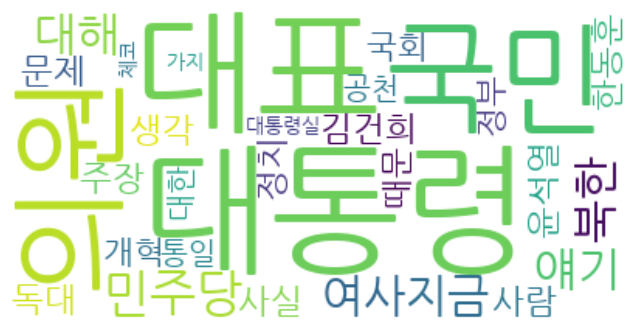

토픽 0의 단어 가중치(빈도수):
대통령: 0.0009872273076325655
대표: 0.000897485064342618
국민: 0.0006761212716810405
의원: 0.0006701977108605206
민주당: 0.0005443672416731715
대해: 0.00047933944733813405
북한: 0.0004729402717202902
얘기: 0.0004710702341981232
여사: 0.0004525061813183129
지금: 0.0004483615921344608
김건희: 0.00041346423677168787
사실: 0.00040737094241194427
문제: 0.00040214468026533723
생각: 0.00039610115345567465
주장: 0.0003838586271740496
윤석열: 0.0003820552956312895
한동훈: 0.00037803934537805617
독대: 0.00037791469367221
사람: 0.00037108108517713845
정치: 0.0003658292116597295
개혁: 0.0003617679758463055
국회: 0.00036172979162074625
때문: 0.00034786370815709233
정부: 0.000346740591339767
통일: 0.0003398324770387262
대한: 0.0003367915633134544
공천: 0.00032853707671165466
대통령실: 0.00032590562477707863
가지: 0.0003156643360853195
체코: 0.00030954883550293744


In [46]:
# 첫 번째 섹션 데이터를 LDA 모델에 적합하게 준비
dictionary, corpus = prepare_data_for_lda(processed_docs[100])  # 100번 섹션을 예시로 사용

# LDA 모델 학습
lda_model = train_lda_model(dictionary, corpus, num_topics=3, passes=15)

# 예시: 첫 번째 토픽에 대한 워드 클라우드 생성 및 단어 가중치(빈도수) 출력
create_word_cloud_with_frequency(lda_model, topic_num=0)